In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense,SpatialDropout1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
#df=pd.read_csv("https://raw.githubusercontent.com/AdrielC/autotradeR/master/Data/autoTradeR-2018-06-17-Private")

In [40]:
#df.to_csv("private_2018_car.csv")

In [41]:
df=pd.read_csv("private_2018_car.csv")
df.dropna(axis=0,subset=["carFeaturesText"],inplace=True)

Index(['Unnamed: 0', 'red', 'green', 'blue', 'rowNum', 'listing_title',
       'listing_distance_miles', 'listing_url', 'price', 'listingPriceRedu',
       'Body Style', 'Drive Type', 'Engine', 'Mileage', 'Transmission',
       'ATC Car ID', 'Fuel', 'Stock #', 'VIN', 'carFeaturesText', 'exterior',
       'interior', 'sellerComment', 'Basic Warranty', 'Corrosion Warranty',
       'Drivetrain Warranty', 'Roadside Assistance Warranty',
       'newListingIndicator', 'Dealer', 'model', 'year', 'ownershipStatus',
       'Location', 'sellerType', 'DriveTypeGeneral', 'numWordsinComment',
       'CityMpg', 'HyMpg'],
      dtype='object')


C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_13548\536047693.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices['price_group'] = pd.cut(df_prices['price'], 10)
C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_13548\536047693.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices['milage_group']=pd.cut(df_prices["Mileage"],10)


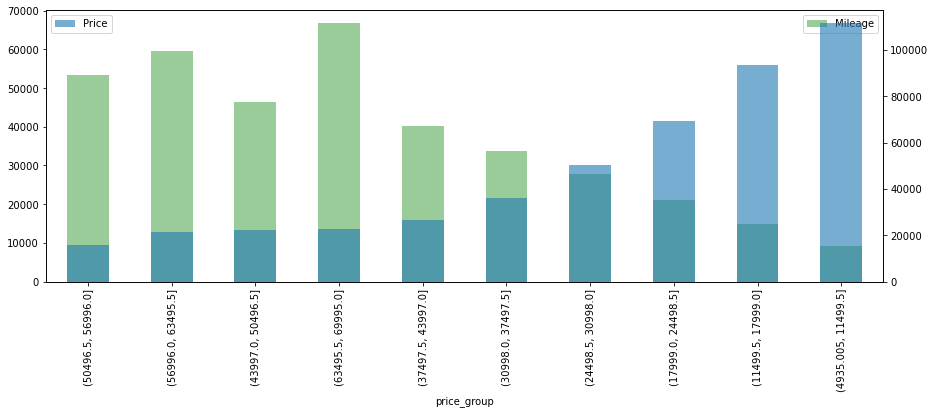

In [42]:
print(df.columns)
mask=df.applymap(np.isreal)

df=df[mask["Mileage"]]

filter=(df["price"]<70000) & (df["Mileage"]<150000) 
df_prices=df[filter]

df_prices['price_group'] = pd.cut(df_prices['price'], 10)
df_prices['milage_group']=pd.cut(df_prices["Mileage"],10)

df_price_grouped = df_prices.groupby('price_group').mean()
df_mileage_grouped = df_prices.groupby('price_group').mean()

#print(mask)'
plt.figure(figsize=(15, 5))

df_price_sorted=df_price_grouped.sort_values(by="Mileage")
df_mileage_sorted=df_mileage_grouped.sort_values(by="Mileage")

df_price_sorted['price'].plot(kind="bar",label="Mileage",color="green",alpha=0.4)
plt.xticks(rotation=90)
plt.legend()
twinx=plt.twinx()
df_mileage_sorted['Mileage'].plot(ax=twinx,kind="bar",label="Price",alpha=0.6)
plt.legend()
plt.show()

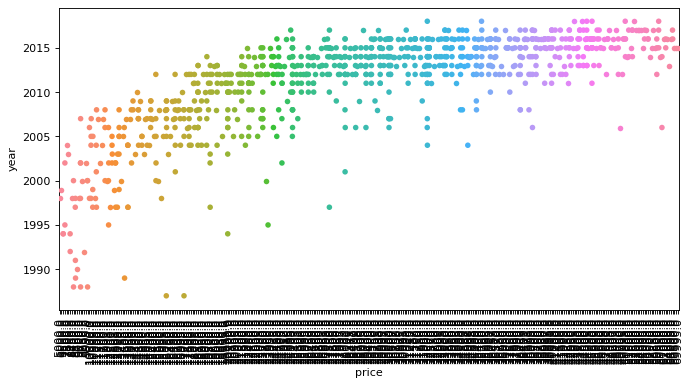

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 74.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 67.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dni

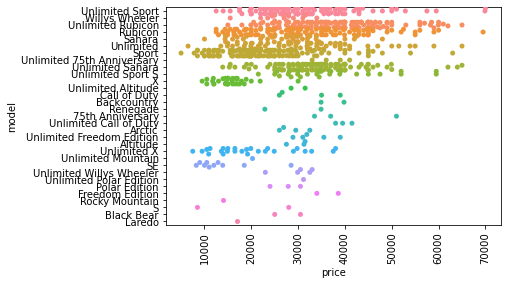

In [17]:
plt.figure(figsize=(10, 5), dpi=80)
sns.stripplot(data=df_prices, y="year", x="price",jitter=True)
plt.xticks(rotation=90)
plt.show()

sns.swarmplot(data=df_prices, y="model", x="price")
plt.xticks(rotation=90)
plt.show()

In [43]:

df_prices["carFeaturesText"]=df_prices["carFeaturesText"].fillna("")
print(df_prices["carFeaturesText"])

0      Backup CameraBluetooth Hands-FreeCD PlayerCrui...
1      Bluetooth Hands-FreeCD PlayerCruise ControlKey...
3      Backup CameraBluetooth Hands-FreeCD PlayerCrui...
4      CD PlayerPremium AudioPremium WheelsTrailer Hitch
5      Bluetooth Hands-FreeCD PlayerCruise ControlDVD...
                             ...                        
994    CD PlayerCruise ControlPremium WheelsSteering ...
996    CD PlayerCruise ControlKeyless EntryLift KitPo...
997    CD PlayerCruise ControlLift KitPremium AudioPr...
998    CD PlayerCruise ControlKeyless EntryLift KitPo...
999    Bluetooth Hands-FreeCruise ControlKeyless Entr...
Name: carFeaturesText, Length: 900, dtype: object


C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_13548\3008371451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices["carFeaturesText"]=df_prices["carFeaturesText"].fillna("")


In [44]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

y = pd.get_dummies(df_prices['price_group']).values
print('Shape of label tensor:', y.shape)

LABELS=sorted(df_prices['price_group'].unique())

print(y)
print(LABELS)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_prices["carFeaturesText"].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df_prices["carFeaturesText"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)

Shape of label tensor: (900, 10)
[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[Interval(4935.005, 11499.5, closed='right'), Interval(11499.5, 17999.0, closed='right'), Interval(17999.0, 24498.5, closed='right'), Interval(24498.5, 30998.0, closed='right'), Interval(30998.0, 37497.5, closed='right'), Interval(37497.5, 43997.0, closed='right'), Interval(43997.0, 50496.5, closed='right'), Interval(50496.5, 56996.0, closed='right'), Interval(56996.0, 63495.5, closed='right'), Interval(63495.5, 69995.0, closed='right')]
Shape of data tensor: (900, 250)


In [28]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
epochs = 500
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/500
12/12 [==============================] - 8s 652ms/step - loss: 1.6436 - accuracy: 0.3325 - val_loss: 1.7173 - val_accuracy: 0.2706
Epoch 2/500
12/12 [==============================] - 8s 692ms/step - loss: 1.6292 - accuracy: 0.3496 - val_loss: 1.7119 - val_accuracy: 0.2706
Epoch 3/500
12/12 [==============================] - 8s 686ms/step - loss: 1.6161 - accuracy: 0.3483 - val_loss: 1.6969 - val_accuracy: 0.2824
Epoch 4/500
12/12 [==============================] - 8s 679ms/step - loss: 1.5765 - accuracy: 0.3707 - val_loss: 1.6568 - val_accuracy: 0.2706
Epoch 5/500
12/12 [==============================] - 8s 667ms/step - loss: 1.5705 - accuracy: 0.3707 - val_loss: 1.6249 - val_accuracy: 0.3294
Epoch 6/500
12/12 [==============================] - 8s 662ms/step - loss: 1.5652 - accuracy: 0.3602 - val_loss: 1.6731 - val_accuracy: 0.2588
Epoch 7/500
12/12 [==============================] - 8s 681ms/step - loss: 1.5556 - accuracy: 0.3813 - val_loss: 1.6339 - val_accuracy: 0.3294

In [32]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 108ms/step - loss: 2.0112 - accuracy: 0.2553
Test set
  Loss: 2.011
  Accuracy: 0.255


In [ ]:
def GetCategory(pred,LABELS):
    returnVal=[]
    curr_index=0
    curr_val=0
    for item in pred:
        val=max(item)
        index=list(item).index(val)
        #print(val,LABELS[index])
        if val>curr_val:
            curr_index=index
            curr_val=val
            
    return LABELS[curr_index]
    #returnVal.append(LABELS[np.argmax(np.array(item))])
    #return returnVal
        
for key,item in df_prices.iterrows():
    data=[]
    data.append(item['carFeaturesText'])
    seq = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    print(pred)
    category=LABELS[np.argmax(pred)]
    print(data, "\n[predicted category]", category, "\n[actual category]",item['price_group'])

1/1 [==============================] - 0s 38ms/step
[[0.00196853 0.00201238 0.01601134 0.04855499 0.20279728 0.24087344
  0.31578377 0.10496997 0.04896183 0.01806646]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitPortable Audio ConnectionPower Locks'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (50496.5, 56996.0]
1/1 [==============================] - 0s 35ms/step
[[0.00122092 0.0068779  0.08693549 0.39125255 0.27532518 0.15914904
  0.03596789 0.0188882  0.01747115 0.00691168]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitPower LocksPower WindowsPremium WheelsSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 33ms/step
[[0.00158647 0.00263684 0.02538826 0.08517355 0.26745468 0.27252126
  0.22355416 0.06707386 0.04064973 0.01396121]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise C

1/1 [==============================] - 0s 51ms/step
[[0.05478951 0.28615904 0.30771068 0.2533837  0.05593792 0.02619804
  0.00636953 0.00306506 0.00463188 0.0017546 ]]
['CD PlayerCruise ControlKeyless EntryPower LocksPower WindowsSecurity SystemTrailer Hitch'] 
[predicted category] (17999.0, 24498.5] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 35ms/step
[[0.00177806 0.00297801 0.03144331 0.1239737  0.25239825 0.2673253
  0.1893595  0.07009506 0.04481531 0.01583349]]
['Bluetooth Hands-FreeCruise ControlHeated SeatsLeather SeatsLift KitNavigationPortable Audio ConnectionPower LocksPower WindowsPremium Audio'] 
[predicted category] (37497.5, 43997.0] 
[actual category] (56996.0, 63495.5]
1/1 [==============================] - 0s 39ms/step
[[0.00175143 0.01827456 0.17713155 0.44662717 0.25632676 0.07028954
  0.01415608 0.00697452 0.00580647 0.00266193]]
['CD PlayerCruise ControlKeyless EntryLift KitPortable Audio ConnectionPower LocksPower WindowsPremium

1/1 [==============================] - 0s 39ms/step
[[0.04153131 0.23994656 0.32459366 0.3105836  0.05008305 0.02207297
  0.00430631 0.00211468 0.00350624 0.00126157]]
['CD PlayerCruise ControlLift KitPortable Audio ConnectionPremium WheelsSecurity SystemSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (17999.0, 24498.5] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 49ms/step
[[0.08824199 0.35943052 0.28667638 0.19497311 0.04033093 0.01810271
  0.00427331 0.0025988  0.00395496 0.00141727]]
['Cruise ControlLift KitPortable Audio ConnectionPremium AudioPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 42ms/step
[[0.00325279 0.03851097 0.1753296  0.47867057 0.20613958 0.07383066
  0.01138619 0.00520777 0.00529643 0.00237542]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsNavigationPortable Audio ConnectionPower LocksPower W

1/1 [==============================] - 0s 42ms/step
[[0.01817889 0.15138231 0.2772348  0.40076444 0.09052385 0.04438705
  0.00763901 0.00333736 0.00474834 0.00180394]]
['Bluetooth Hands-FreeCD PlayerCruise ControlNavigationPower LocksPower WindowsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 49ms/step
[[0.00150565 0.01199837 0.09795322 0.36384466 0.33238253 0.13498789
  0.02690034 0.01378901 0.01148436 0.005154  ]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitPortable Audio ConnectionPower LocksPower WindowsPremium AudioPremium Wheels'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 41ms/step
[[0.00149954 0.00179783 0.01760127 0.05505264 0.2315527  0.24773057
  0.3183913  0.07550069 0.03712988 0.01374366]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerKeyless EntryLeather SeatsLift

1/1 [==============================] - 0s 36ms/step
[[0.18045032 0.42360607 0.23186222 0.11514898 0.02526696 0.01196562
  0.00349748 0.00280847 0.0040481  0.00134582]]
['CD PlayerCruise ControlLift KitPremium AudioTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 35ms/step
[[0.16304117 0.3853048  0.24682294 0.13957576 0.03523714 0.01465467
  0.00478421 0.00371991 0.00500517 0.00185419]]
['CD PlayerLift KitPremium Wheels'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 58ms/step
[[0.00146915 0.00952681 0.1011392  0.42994478 0.24676749 0.14828488
  0.02786454 0.01496286 0.01423233 0.00580794]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitNavigationPower LocksPower WindowsSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [=================

1/1 [==============================] - 0s 37ms/step
[[0.00147954 0.00136075 0.01227219 0.03581664 0.18002959 0.23546016
  0.39143756 0.08916003 0.03786942 0.01511408]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitMulti-zone Climate ControlNavigation'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (43997.0, 50496.5]
1/1 [==============================] - 0s 36ms/step
[[0.19378063 0.4161944  0.23125242 0.11041224 0.02466482 0.01172229
  0.00359151 0.00291713 0.00407722 0.00138733]]
['CD PlayerLift KitPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 40ms/step
[[0.00219691 0.02368965 0.20668335 0.42738166 0.24533822 0.06607901
  0.01478145 0.00603689 0.00526403 0.00254878]]
['Bluetooth Hands-FreeCruise ControlDVD PlayerKeyless EntryPower LocksPower WindowsPremium AudioPremium WheelsSteering Wheel Controls'] 
[predicte

1/1 [==============================] - 0s 41ms/step
[[0.18045032 0.42360607 0.23186222 0.11514898 0.02526696 0.01196562
  0.00349748 0.00280847 0.0040481  0.00134582]]
['CD PlayerCruise ControlLift KitPremium AudioTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (4935.005, 11499.5]
1/1 [==============================] - 0s 41ms/step
[[0.00229454 0.02319705 0.15524325 0.53454643 0.16965376 0.08980252
  0.01075214 0.00574928 0.00624844 0.00251264]]
['Bluetooth Hands-FreeCruise ControlLift KitPower LocksPower WindowsSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 37ms/step
[[0.00199937 0.00207467 0.01610459 0.05656024 0.21599604 0.24382646
  0.29974365 0.09736471 0.04739141 0.01893892]]
['Backup CameraBluetooth Hands-FreeCruise ControlHeated SeatsKeyless EntryLift KitMulti-zone Climate ControlPortable Audio ConnectionPower LocksPower Windows'] 
[predic

1/1 [==============================] - 0s 46ms/step
[[0.00138065 0.00633789 0.07862402 0.26701266 0.33953434 0.19133924
  0.06454758 0.0244618  0.01906618 0.0076956 ]]
['Bluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsNavigationPower LocksPower WindowsPremium Audio'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 50ms/step
[[0.00140313 0.00323106 0.04098255 0.16038465 0.29817867 0.2538985
  0.14334571 0.05063097 0.03538791 0.01255684]]
['3rd Row SeatsBluetooth Hands-FreeCruise ControlHeated SeatsKeyless EntryLeather SeatsNavigationPower LocksPower WindowsPremium Audio'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 49ms/step
[[0.00170467 0.00174143 0.01597267 0.0467268  0.20344897 0.24759138
  0.33952007 0.08648004 0.04128983 0.01552409]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated Seat

1/1 [==============================] - 0s 77ms/step
[[0.1379198  0.40719014 0.2555261  0.14164682 0.03084866 0.01445264
  0.00402867 0.00281967 0.00412087 0.00144664]]
['Bluetooth Hands-FreeLift KitPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 36ms/step
[[0.00170467 0.00174143 0.01597267 0.0467268  0.20344897 0.24759138
  0.33952007 0.08648004 0.04128983 0.01552409]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitNavigationPortable Audio Connection'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (43997.0, 50496.5]
1/1 [==============================] - 0s 32ms/step
[[0.12842718 0.38923535 0.26950857 0.15201005 0.03296091 0.01530074
  0.00412092 0.00280241 0.00416387 0.00146999]]
['CD PlayerLift KitNavigationPortable Audio ConnectionPremium AudioPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0

[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 36ms/step
[[0.00142648 0.00658819 0.06762192 0.28334224 0.35944986 0.17316012
  0.05347351 0.02566475 0.02092272 0.00835019]]
['Bluetooth Hands-FreeCruise ControlHeated SeatsLeather SeatsMulti-zone Climate ControlNavigationPower WindowsPremium AudioPremium WheelsSecurity System'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 39ms/step
[[0.00139126 0.00419991 0.04177073 0.16753054 0.32205883 0.2626678
  0.11586595 0.04219973 0.03109357 0.01122162]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLeather SeatsLift KitPower LocksPower WindowsPremium AudioPremium Wheels'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 42ms/step
[[0.0014192  0.00358884 0.03589461 0.07423568 0.33877844 0.24901924
  0.21932033 0.04512219 0.02344283 0.00917864]]
['Bluetooth Ha

1/1 [==============================] - 0s 44ms/step
[[0.00573602 0.06088124 0.20443715 0.4571306  0.18203148 0.06589606
  0.01123132 0.0049366  0.00525946 0.00246007]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryPower LocksPower WindowsPremium AudioPremium WheelsSecurity System'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 43ms/step
[[0.00147615 0.00211787 0.02109704 0.0510061  0.26860452 0.2435477
  0.29740846 0.06898854 0.03389506 0.01185856]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerKeyless EntryLeather SeatsLift KitNavigationPower Locks'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (50496.5, 56996.0]
1/1 [==============================] - 0s 42ms/step
[[0.00212535 0.00730256 0.05903587 0.21291488 0.3306151  0.22552702
  0.08543563 0.03709354 0.02855297 0.01139706]]
['Backup CameraBluetooth Hands-FreeCruise ControlKeyless EntryLift KitPremium AudioPre

1/1 [==============================] - 0s 40ms/step
[[0.00853556 0.07635889 0.22667395 0.45823967 0.13165341 0.07461675
  0.00992428 0.00526    0.00629846 0.00243907]]
['CD PlayerCruise ControlKeyless EntryLift KitPower LocksPower WindowsPremium AudioPremium WheelsSunroofTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 44ms/step
[[0.10089223 0.35917205 0.29514974 0.17508005 0.03876928 0.01745553
  0.00486809 0.00285376 0.00420244 0.00155696]]
['CD PlayerCruise ControlPortable Audio ConnectionPremium WheelsSecurity SystemTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 44ms/step
[[0.00169765 0.01406693 0.12855732 0.42509758 0.28713673 0.10054853
  0.02001826 0.01031243 0.00874177 0.00382286]]
['CD PlayerCruise ControlHeated SeatsLeather SeatsMulti-zone Climate ControlNavigationPortable Audio ConnectionPower LocksP

1/1 [==============================] - 0s 47ms/step
[[0.00150359 0.00989269 0.08964264 0.31820056 0.34832177 0.15698913
  0.03854296 0.0170145  0.0137506  0.00614151]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitPower LocksPower WindowsPremium AudioPremium WheelsSecurity System'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 49ms/step
[[0.00111214 0.00151427 0.0174895  0.05139711 0.24926339 0.25521302
  0.31902513 0.063201   0.03065728 0.0111272 ]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLift KitNavigationPower LocksPower Windows'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 52ms/step
[[0.0014055  0.00803167 0.09296658 0.29700777 0.34574708 0.16521141
  0.04900704 0.01909019 0.0150208  0.00651201]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsKeyless 

1/1 [==============================] - 0s 41ms/step
[[0.00202369 0.00234696 0.01913035 0.05531478 0.22826459 0.24591124
  0.29207647 0.09218963 0.04641426 0.01632804]]
['Backup CameraBluetooth Hands-FreeCruise ControlDVD PlayerKeyless EntryLeather SeatsLift KitNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (56996.0, 63495.5]
1/1 [==============================] - 0s 42ms/step
[[0.00911844 0.08003073 0.30787444 0.43018034 0.12165243 0.03460063
  0.00796492 0.00308139 0.00379781 0.00169888]]
['CD PlayerCruise ControlKeyless EntryPower LocksPower WindowsPremium AudioPremium WheelsSecurity SystemSteering Wheel Controls'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 48ms/step
[[0.12423234 0.38384923 0.2776496  0.15547074 0.03229955 0.01470324
  0.003864   0.00263717 0.0039355  0.00135869]]
['CD PlayerCruise ControlLift KitPortable Audio ConnectionPremium 

1/1 [==============================] - 0s 39ms/step
[[0.01614627 0.12839048 0.25647697 0.3859526  0.13786614 0.05136098
  0.01054676 0.00488559 0.0057157  0.00265841]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerLift KitNavigationPortable Audio ConnectionPremium AudioPremium WheelsSecurity System'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 41ms/step
[[0.00193437 0.0035933  0.03198571 0.11735729 0.29872915 0.25000164
  0.171503   0.06807717 0.0424713  0.01434699]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 41ms/step
[[0.00147954 0.00136075 0.01227219 0.03581664 0.18002959 0.23546016
  0.39143756 0.08916003 0.03786942 0.01511408]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise

1/1 [==============================] - 0s 37ms/step
[[0.00134653 0.00395145 0.04340489 0.16221148 0.3238013  0.25269902
  0.12931181 0.04250813 0.02969101 0.0110743 ]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLeather SeatsLift KitPower LocksPower WindowsPremium WheelsSecurity System'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 36ms/step
[[0.00141001 0.00858849 0.08721765 0.22149949 0.4032689  0.17666434
  0.06654639 0.01733952 0.01181815 0.00564711]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsKeyless EntryLeather SeatsNavigationPower LocksPower Windows'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 35ms/step
[[0.00173925 0.00319886 0.03314925 0.11273059 0.3149565  0.24493325
  0.18285681 0.05764223 0.03593961 0.01285366]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeate

1/1 [==============================] - 0s 48ms/step
[[0.00416501 0.04161763 0.25575364 0.4317112  0.19069822 0.05220686
  0.01201723 0.00480506 0.0047409  0.00228421]]
['Bluetooth Hands-FreeCD PlayerCruise ControlLift KitPortable Audio ConnectionPremium AudioPremium WheelsSteering Wheel Controls'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 50ms/step
[[0.00511885 0.04566481 0.19511767 0.41530213 0.20741552 0.09564564
  0.01835748 0.00693229 0.00720222 0.0032434 ]]
['CD PlayerCruise ControlKeyless EntryLift KitPower LocksPower WindowsPremium Wheels'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 45ms/step
[[0.00208473 0.00202785 0.01518075 0.05069508 0.20405018 0.23976958
  0.31709364 0.10124042 0.04826863 0.01958911]]
['Backup CameraBluetooth Hands-FreeCruise ControlKeyless EntryLeather SeatsLift KitMulti-zone Climate ControlPortable Au

1/1 [==============================] - 0s 37ms/step
[[0.00337561 0.03755229 0.17306843 0.45948002 0.22301373 0.07669568
  0.01263236 0.005893   0.0056055  0.00268333]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryPortable Audio ConnectionPower LocksPower WindowsPremium AudioPremium WheelsSecurity System'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 37ms/step
[[0.00597045 0.06188112 0.22319454 0.5123636  0.11887321 0.05989718
  0.00775571 0.00364792 0.00462564 0.00179051]]
['Bluetooth Hands-FreeCruise ControlPremium AudioPremium WheelsSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 57ms/step
[[0.00142533 0.00959271 0.10204139 0.44568107 0.25096434 0.13431779
  0.02379848 0.01369958 0.01319007 0.00528923]]
['Cruise ControlHeated SeatsLeather SeatsPower LocksPower WindowsPremium AudioPremiu

1/1 [==============================] - 0s 43ms/step
[[0.08991522 0.3393343  0.27345815 0.2019551  0.05267387 0.02347196
  0.00723165 0.0041105  0.00568181 0.0021674 ]]
['Bluetooth Hands-FreeCD PlayerLift Kit'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 43ms/step
[[0.01734681 0.13773414 0.26445222 0.4096141  0.09828994 0.05284476
  0.00829337 0.00397704 0.00540608 0.00204159]]
['Backup CameraCruise ControlDVD PlayerNavigationPower LocksPower WindowsPremium WheelsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 41ms/step
[[0.00150359 0.00989269 0.08964264 0.31820056 0.34832177 0.15698913
  0.03854296 0.0170145  0.0137506  0.00614151]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitPower LocksPower WindowsPremium AudioPremium WheelsSecurity System'] 
[predicted category] (30998.0, 37497.5] 
[actual category

1/1 [==============================] - 0s 52ms/step
[[0.00169631 0.00559076 0.05258717 0.1878645  0.3744316  0.20265928
  0.09712968 0.04034125 0.02782174 0.00987769]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsLift KitMulti-zone Climate ControlNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 47ms/step
[[0.00170467 0.00174143 0.01597267 0.0467268  0.20344897 0.24759138
  0.33952007 0.08648004 0.04128983 0.01552409]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitNavigationPortable Audio Connection'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 43ms/step
[[0.0025359  0.01792354 0.1162464  0.44952834 0.23729941 0.12779488
  0.01929049 0.01241491 0.01203083 0.00493518]]
['Bluetooth Hands-FreeCruise ControlKeyless En

1/1 [==============================] - 0s 45ms/step
[[0.1682437  0.38252825 0.25232103 0.13317466 0.03363847 0.01416361
  0.00528532 0.00378293 0.00497001 0.00189207]]
['CD PlayerCruise Control'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 45ms/step
[[0.16495863 0.35586753 0.25900334 0.14253055 0.04173647 0.01698455
  0.00656703 0.00452402 0.0056407  0.00218718]]
['Power Windows'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 41ms/step
[[0.001688   0.00249018 0.02287633 0.06401248 0.25602984 0.25734332
  0.26887992 0.0741927  0.0391698  0.01331744]]
['Bluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 43ms/step
[[0.00178446 0.011338

1/1 [==============================] - 0s 37ms/step
[[0.12357451 0.3473575  0.28247112 0.17260525 0.04235732 0.01637481
  0.00506864 0.00350308 0.00483439 0.00185334]]
['Premium Wheels'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 36ms/step
[[0.17074032 0.40767005 0.24503998 0.12396259 0.02736144 0.01289967
  0.00383402 0.00291714 0.00414696 0.00142787]]
['Lift KitPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 42ms/step
[[0.00163942 0.00399228 0.04144446 0.11259788 0.33436802 0.25011617
  0.17464757 0.04403554 0.026992   0.01016663]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsKeyless EntryLeather SeatsLift KitNavigationPortable Audio Connection'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 41ms/step
[[0.00141

1/1 [==============================] - 0s 47ms/step
[[0.00190917 0.00268544 0.02560156 0.07755504 0.26749206 0.2536788
  0.24726172 0.07007682 0.03955422 0.01418516]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerKeyless EntryLeather SeatsLift KitNavigationPortable Audio Connection'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 51ms/step
[[0.00191221 0.00303278 0.02613062 0.10013594 0.2754298  0.25043023
  0.20275746 0.07872713 0.04601677 0.01542701]]
['Bluetooth Hands-FreeCD PlayerCruise ControlHeated SeatsLeather SeatsLift KitMulti-zone Climate ControlNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 46ms/step
[[0.001688   0.00249018 0.02287633 0.06401248 0.25602984 0.25734332
  0.26887992 0.0741927  0.0391698  0.01331744]]
['Bluetooth Hands-FreeCD PlayerCruise ControlH

  0.00702113 0.00394866 0.00479533 0.00199258]]
['Bluetooth Hands-FreeCD PlayerDVD PlayerLift KitMulti-zone Climate ControlNavigationPortable Audio ConnectionPremium AudioPremium WheelsSunroof'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 46ms/step
[[0.02220665 0.17355058 0.26155254 0.35864305 0.11262542 0.04853189
  0.0099504  0.00457222 0.00593627 0.00243098]]
['Bluetooth Hands-FreeCD PlayerCruise ControlLift KitPremium AudioPremium Wheels'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 39ms/step
[[0.00325158 0.03709602 0.18809023 0.554252   0.13664818 0.06316127
  0.00723531 0.00398816 0.00446014 0.00181713]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryPortable Audio ConnectionPower LocksPower WindowsPremium AudioSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5,

1/1 [==============================] - 0s 43ms/step
[[0.00128231 0.0017454  0.01902149 0.05181539 0.25457764 0.25500286
  0.31244013 0.06199934 0.03090807 0.0112074 ]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerLeather SeatsLift KitNavigationPower LocksPower Windows'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (43997.0, 50496.5]
1/1 [==============================] - 0s 40ms/step
[[0.08447    0.36175546 0.27748957 0.19750002 0.04307605 0.02132776
  0.00517538 0.00303104 0.00455928 0.00161541]]
['Bluetooth Hands-FreeCD PlayerLift KitPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (4935.005, 11499.5]
1/1 [==============================] - 0s 43ms/step
[[0.0469816  0.21209243 0.3395043  0.29467258 0.06614324 0.02461594
  0.00651133 0.00307631 0.00460338 0.00179901]]
['CD PlayerCruise ControlKeyless EntryPower LocksPower WindowsPremium Audio'] 
[predicted category] (17999.0, 24498.5] 
[actual category] (244

1/1 [==============================] - 0s 43ms/step
[[0.0185558  0.14450473 0.29401302 0.41246173 0.07670172 0.03852256
  0.00646334 0.00283845 0.00434498 0.00159361]]
['CD PlayerCruise ControlLift KitPremium AudioPremium WheelsSteering Wheel ControlsTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 42ms/step
[[0.00192828 0.00173195 0.01331026 0.03596542 0.17893437 0.23223837
  0.36269623 0.10805111 0.04727224 0.01787183]]
['Backup CameraBluetooth Hands-FreeCruise ControlHeated SeatsKeyless EntryLeather SeatsLift KitNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (43997.0, 50496.5] 
[actual category] (50496.5, 56996.0]
1/1 [==============================] - 0s 42ms/step
[[0.00198753 0.01248062 0.09518844 0.28618813 0.3807155  0.1401752
  0.04316005 0.01994963 0.01418787 0.00596707]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerKeyless EntryLift KitMulti-zone Climate C

[[0.00197244 0.01427682 0.10383686 0.3181217  0.37081057 0.1231993
  0.03407102 0.01662427 0.01198685 0.00510027]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsLeather SeatsMulti-zone Climate ControlNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (30998.0, 37497.5]
1/1 [==============================] - 0s 46ms/step
[[0.05830681 0.29383862 0.30327746 0.25721788 0.05042719 0.02339448
  0.00512121 0.00268052 0.00422095 0.00151482]]
['CD PlayerCruise ControlKeyless EntryPower LocksPower WindowsPremium WheelsTrailer Hitch'] 
[predicted category] (17999.0, 24498.5] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 35ms/step
[[0.00488986 0.04693345 0.23557642 0.44006866 0.19683495 0.05267169
  0.01188222 0.00429436 0.00476629 0.00208207]]
['CD PlayerCruise ControlKeyless EntryPortable Audio ConnectionPower LocksPower WindowsPremium WheelsSecurity SystemSteering Wheel ControlsSunro

1/1 [==============================] - 0s 47ms/step
[[0.00094345 0.00227009 0.03555834 0.12108485 0.366059   0.2165423
  0.17361176 0.04515382 0.02919115 0.00958525]]
['Bluetooth Hands-FreeCruise ControlHeated SeatsKeyless EntryLift KitPower LocksPower WindowsPremium WheelsSteering Wheel ControlsSunroof'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 45ms/step
[[0.00211263 0.0188974  0.15349221 0.4770771  0.21073523 0.10191365
  0.01581294 0.00850737 0.00811851 0.00333284]]
['Bluetooth Hands-FreeCruise ControlLift KitPower LocksPower WindowsPremium AudioSteering Wheel ControlsSunroofTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 48ms/step
[[0.00175033 0.00831253 0.08697915 0.32093656 0.33015487 0.15916373
  0.04469024 0.0219891  0.01859653 0.00742697]]
['Backup CameraBluetooth Hands-FreeCD PlayerDVD PlayerHeated SeatsKeyles

1/1 [==============================] - 0s 52ms/step
[[0.16304117 0.3853048  0.24682294 0.13957576 0.03523714 0.01465467
  0.00478421 0.00371991 0.00500517 0.00185419]]
['CD PlayerLift KitPremium Wheels'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (4935.005, 11499.5]
1/1 [==============================] - 0s 64ms/step
[[0.00894182 0.08383229 0.2210198  0.4295873  0.14984089 0.07942895
  0.01240696 0.00575495 0.00649805 0.00268892]]
['CD PlayerCruise ControlLift KitPower LocksPower WindowsPremium AudioPremium WheelsSecurity SystemTrailer Hitch'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 66ms/step
[[0.00447393 0.02073142 0.10094479 0.32766917 0.299418   0.15641372
  0.03570775 0.02422887 0.02154442 0.0088679 ]]
['Backup CameraBluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerLift KitNavigationPortable Audio ConnectionPremium AudioPremium Wheels'] 
[predicted category] (24498.5, 30998.0] 
[ac

1/1 [==============================] - 0s 29ms/step
[[0.19378063 0.4161944  0.23125242 0.11041224 0.02466482 0.01172229
  0.00359151 0.00291713 0.00407722 0.00138733]]
['CD PlayerLift KitPremium WheelsTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 30ms/step
[[0.00174856 0.00427252 0.0392787  0.10627548 0.32969785 0.24682026
  0.17851275 0.05172705 0.03066956 0.01099731]]
['Bluetooth Hands-FreeCD PlayerCruise ControlDVD PlayerHeated SeatsLeather SeatsLift KitNavigationPortable Audio ConnectionPower Locks'] 
[predicted category] (30998.0, 37497.5] 
[actual category] (37497.5, 43997.0]
1/1 [==============================] - 0s 35ms/step
[[0.18827643 0.36118615 0.26350278 0.12762484 0.0318129  0.01295814
  0.00453736 0.00361413 0.00478189 0.00170538]]
['CD PlayerLift KitPremium Audio'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] -

1/1 [==============================] - 0s 45ms/step
[[0.00146398 0.01110663 0.10289001 0.35345507 0.3395581  0.13042569
  0.03053176 0.01415586 0.01119317 0.00521968]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryLift KitPortable Audio ConnectionPower LocksPower WindowsPremium WheelsSecurity System'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (17999.0, 24498.5]
1/1 [==============================] - 0s 38ms/step
[[0.00158363 0.00273875 0.02605271 0.10718788 0.2582119  0.27886036
  0.19624205 0.06989168 0.04410355 0.01512745]]
['Bluetooth Hands-FreeCruise ControlHeated SeatsLeather SeatsLift KitNavigationPortable Audio ConnectionPower LocksPower WindowsPremium Wheels'] 
[predicted category] (37497.5, 43997.0] 
[actual category] (50496.5, 56996.0]
1/1 [==============================] - 0s 36ms/step
[[0.001546   0.01477349 0.15904851 0.42397693 0.28209755 0.08270749
  0.01746715 0.0084405  0.00686641 0.00307592]]
['Bluetooth Hands-FreeCruise ControlLift KitPo

1/1 [==============================] - 0s 34ms/step
[[0.01273059 0.10997026 0.25967056 0.4217039  0.1278529  0.04731492
  0.00969965 0.00389966 0.00497431 0.00218331]]
['Bluetooth Hands-FreeCD PlayerCruise ControlKeyless EntryPower LocksPower WindowsSecurity System'] 
[predicted category] (24498.5, 30998.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 31ms/step
[[0.24562314 0.42237338 0.19835015 0.09147671 0.02095518 0.01000606
  0.00304585 0.0029312  0.00397206 0.00126636]]
['CD PlayerTrailer Hitch'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (11499.5, 17999.0]
1/1 [==============================] - 0s 30ms/step
[[0.1316005  0.35377857 0.2744561  0.16608053 0.040663   0.01658343
  0.00594321 0.00378962 0.0051075  0.00199749]]
['Cruise Control'] 
[predicted category] (11499.5, 17999.0] 
[actual category] (24498.5, 30998.0]
1/1 [==============================] - 0s 39ms/step
[[0.00154626 0.00402339 0.04389887 0.14861247 0.36788797 0.21